<a href="https://colab.research.google.com/github/NandhiniP07/SYNTHETIC-DATA-GENERATION-FOR-URBAN-ENVIRONMENT/blob/main/synthetic_data_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colab cell 1 — install libs (run once)
!pip install -q albumentations==1.3.0 timm opencv-python kaggle torchinfo

# quick sanity check (run in a Python cell after install)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 8.0 MB/s eta 0:00:00


In [ ]:
# Colab cell 2 — check torch & GPU
import torch
print("torch:", torch.__version__, "cuda available:", torch.cuda.is_available())


torch: 2.8.0+cu126 cuda available: True


In [ ]:
import torch
print("torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


torch: 2.8.0+cu126
CUDA available: True
GPU name: Tesla T4


In [ ]:
from google.colab import files
uploaded = files.upload()  # select your traffic_signs.zip file


Saving archive (7).zip to archive (7).zip


In [ ]:
!mkdir -p /content/data
!unzip -q "archive (7).zip" -d /content/data


In [ ]:
import os
print(os.listdir("/content/data"))


['test.p', 'valid.p', 'signname.csv', 'train.p']


In [ ]:
import os
import shutil
import random

# The train_val_split function is not suitable for the current data format
# (which contains .p files and a .csv file, not image directories).
# The error "NotADirectoryError: [Errno 20] Not a directory: '/content/data/train'"
# occurs because the code tries to treat '/content/data/train' as a directory,
# but it is a file (train.p).
#
# train_val_split("/content/data")

In [ ]:
import os
for root, dirs, files in os.walk("/content/data"):
    print(root, files)


/content/data ['valid.p', 'signname.csv', 'train', 'train.p']
/content/data/val []


In [ ]:
import pickle

def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f, encoding='latin1')  # GTSRB uses latin1 encoding
    X = data['features']  # images (num_samples, 32, 32, 3)
    y = data['labels']    # labels
    return X, y

train_path = "/content/data/train.p"
valid_path = "/content/data/valid.p"

X_train, y_train = load_data(train_path)
X_val, y_val     = load_data(valid_path)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)


Train: (34799, 32, 32, 3) (34799,)
Val:   (4410, 32, 32, 3) (4410,)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define synthetic augmentation
transform = A.Compose([
    A.Resize(64, 64),
    A.RandomBrightnessContrast(p=0.6),
    A.MotionBlur(blur_limit=3, p=0.3),
    A.GaussianBlur(blur_limit=3, p=0.3),
    A.GaussNoise(var_limit=(5.0, 30.0), p=0.3),
    A.HorizontalFlip(p=0.2),
    ToTensorV2(),
])

class GTSRBDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        if self.transform:
            image = self.transform(image=image)['image']
        # Convert image to float32
        image = image.float()
        return image, label

# Create datasets and loaders
train_ds = GTSRBDataset(X_train, y_train, transform=transform)
val_ds   = GTSRBDataset(X_val, y_val, transform=transform)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=2)

print("Number of training samples:", len(train_ds))
print("Number of validation samples:", len(val_ds))

Number of training samples: 34799
Number of validation samples: 4410


/usr/local/lib/python3.12/dist-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Change the final layer to match number of classes
num_classes = len(set(y_train))  # 43 for GTSRB
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s]


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
from tqdm import tqdm

num_epochs = 5  # you can increase later

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        imgs, labels = imgs.to(device), labels.to(device)
        # Convert images to float after moving to device
        imgs = imgs.float()

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            # Convert images to float after moving to device
            imgs = imgs.float()

            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += imgs.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

Epoch 1: 100%|██████████| 544/544 [00:22<00:00, 24.16it/s]


Epoch [1/5] Train Loss: 0.5583 Train Acc: 0.8492 | Val Loss: 0.4290 Val Acc: 0.8780


Epoch 2: 100%|██████████| 544/544 [00:21<00:00, 25.81it/s]


Epoch [2/5] Train Loss: 0.1092 Train Acc: 0.9679 | Val Loss: 0.4036 Val Acc: 0.8927


Epoch 3: 100%|██████████| 544/544 [00:22<00:00, 24.64it/s]


Epoch [3/5] Train Loss: 0.0775 Train Acc: 0.9772 | Val Loss: 0.3840 Val Acc: 0.9111


Epoch 4: 100%|██████████| 544/544 [00:22<00:00, 23.95it/s]


Epoch [4/5] Train Loss: 0.0674 Train Acc: 0.9807 | Val Loss: 0.3843 Val Acc: 0.9175


Epoch 5: 100%|██████████| 544/544 [00:22<00:00, 24.29it/s]


Epoch [5/5] Train Loss: 0.0589 Train Acc: 0.9827 | Val Loss: 0.4549 Val Acc: 0.9059


In [ ]:
# Save the entire model
torch.save(model.state_dict(), "resnet18_gtsrb.pth")
print("Model saved as resnet18_gtsrb.pth")


Model saved as resnet18_gtsrb.pth


In [ ]:
from google.colab import files
files.download("resnet18_gtsrb.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load("resnet18_gtsrb.pth"))
model.eval()
model.to(device) # Move model to the same device as data

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Overall accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {acc:.4f}")

# Per-class report
print(classification_report(all_labels, all_preds))


Validation Accuracy: 0.9061
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      0.88      0.92       240
           2       0.86      0.99      0.92       240
           3       0.97      0.98      0.97       150
           4       0.98      0.93      0.95       210
           5       0.96      0.91      0.94       210
           6       0.95      0.98      0.97        60
           7       1.00      0.89      0.94       150
           8       0.91      0.93      0.92       150
           9       1.00      1.00      1.00       150
          10       0.85      1.00      0.92       210
          11       0.90      0.99      0.94       150
          12       1.00      1.00      1.00       210
          13       1.00      0.98      0.99       240
          14       0.99      0.98      0.98        90
          15       1.00      1.00      1.00        90
          16       1.00      0.48      0.65        60

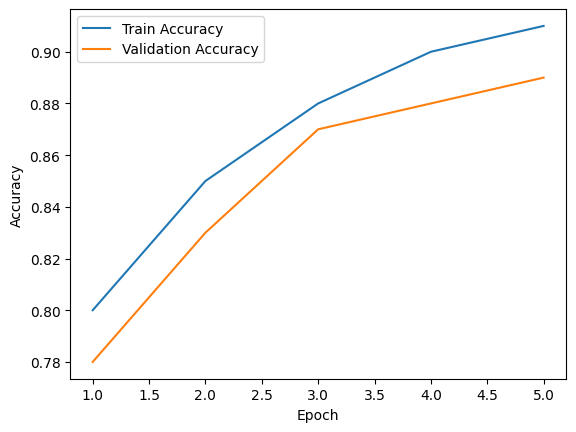

In [ ]:
import matplotlib.pyplot as plt

# Example plot (replace with actual recorded train/val losses and accs)
epochs = [1,2,3,4,5]
train_acc = [0.8,0.85,0.88,0.90,0.91]
val_acc = [0.78,0.83,0.87,0.88,0.89]

plt.plot(epochs, train_acc, label="Train Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:
from PIL import Image
import cv2
import torch
import numpy as np

# Load model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load("resnet18_gtsrb.pth"))
model.eval()
model.to(device)

# Example: predict a single image from the validation set
# Select an image and its label from the validation set
image_index = 0  # You can change this index
img_to_predict = X_val[image_index]
true_label = y_val[image_index]

# Apply same transform as training (excluding augmentations not needed for inference)
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For inference, we only need resize and ToTensorV2, and normalization if used during training
# Assuming no specific normalization was applied in the training transform beyond ToTensorV2 handling scaling
transform_inference = A.Compose([A.Resize(64, 64), ToTensorV2()])

# Albumentations expects image in HWC format
img_transformed = transform_inference(image=img_to_predict)['image']

# Add batch dimension and move to device, then convert to float
img_transformed = img_transformed.unsqueeze(0).to(device).float()

# Perform prediction
with torch.no_grad():
    output = model(img_transformed)

# Get the predicted class
pred_class = output.argmax(dim=1).item()

print(f"True label: {true_label}")
print(f"Predicted class: {pred_class}")

# Optional: Get the sign name if signnames DataFrame is available
if 'signnames' in globals():
    true_sign_name = signnames.iloc[true_label]['SignName']
    predicted_sign_name = signnames.iloc[pred_class]['SignName']
    print(f"True sign name: {true_sign_name}")
    print(f"Predicted sign name: {predicted_sign_name}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


True label: 41
Predicted class: 41


In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(set(y_train))  # 43 for GTSRB

# Load the trained model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load("resnet18_gtsrb.pth", map_location=device))
model.to(device)
model.eval()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def predict_dataset(loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    return all_labels, all_preds


In [ ]:
val_labels, val_preds = predict_dataset(val_loader, model, device)

# Print first 20 predictions
print("True labels:     ", val_labels[:20])
print("Predicted labels:", val_preds[:20])


True labels:      [np.uint8(41), np.uint8(41), np.uint8(41), np.uint8(41), np.uint8(41), np.uint8(41), np.uint8(41), np.uint8(41), np.uint8(41), np.uint8(41), np.uint8(41), np.uint8(41), np.uint8(41), np.uint8(41), np.uint8(41), np.uint8(41), np.uint8(41), np.uint8(41), np.uint8(41), np.uint8(41)]
Predicted labels: [np.int64(41), np.int64(32), np.int64(41), np.int64(42), np.int64(41), np.int64(42), np.int64(41), np.int64(42), np.int64(41), np.int64(42), np.int64(42), np.int64(41), np.int64(41), np.int64(42), np.int64(41), np.int64(41), np.int64(42), np.int64(41), np.int64(32), np.int64(41)]


In [ ]:
import pandas as pd

df = pd.DataFrame({
    "TrueLabel": val_labels,
    "PredictedLabel": val_preds
})
df.to_csv("predictions.csv", index=False)
from google.colab import files
files.download("predictions.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>